In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
member_data = pd.read_csv('member_sample.csv')

# Display the first few rows
member_data.head()

# Data exploration
def explore_data(df):
    """
    Display basic information and statistics of the dataset.
    """
    print("Data Overview:")
    print(df.head(), "\n")
    print("Data Types:")
    print(df.info(), "\n")
    print("Missing Values:")
    print(df.isnull().sum())

# Explore the member data
explore_data(member_data)

# Data Preprocessing Function
def preprocess_data(df):
    """
    Clean, preprocess, and engineer features for the dataset.
    """
    # Check if necessary columns exist and handle NaN values accordingly
    required_columns = ['Member Status', 'Income', 'Credit Ranges', 'Number of Children',
                        'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
                        'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                        'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag',
                        'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3',
                        'Plus Indicator Description']

    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        return None

    # Remove canceled members
    df = df[df['Member Status'] != 'Canceled']

    # Convert 'Income' to numeric using midpoints of ranges
    income_mapping = {
        'Under 10K': 5000,
        '10-19,999': 15000,
        '20-29,999': 25000,
        '30-39,999': 35000,
        '40-49,999': 45000,
        '50-59,999': 55000,
        '60-69,999': 65000,
        '70-79,999': 75000,
        '80-89,999': 85000,
        '90-99,999': 95000,
        '100-149,999': 125000,
        '150 - 174,999': 162500,
        '175 - 199,999': 187500,
        '200 - 249,999': 225000,
        '250K+': 250000
    }
    df['Income'] = df['Income'].replace(income_mapping).astype(float)

    # Convert 'Credit Ranges' to numeric using midpoints of ranges
    credit_mapping = {
        '499 & Less': 499,
        '500-549': 525,
        '550-599': 575,
        '600-649': 625,
        '650-699': 675,
        '700-749': 725,
        '750-799': 775,
        '800+': 800,
        'Unknown': np.nan
    }
    df['Credit Ranges'] = df['Credit Ranges'].replace(credit_mapping).astype(float)

    # Handle missing values for 'Income' and 'Credit Ranges'
    df['Income'].fillna(df['Income'].median(), inplace=True)
    df['Credit Ranges'].fillna(df['Credit Ranges'].median(), inplace=True)

    # Convert 'Number of Children' to numeric based on text descriptions
    children_mapping = {
        'No children': 0,
        'One Child': 1,
        'Two Children': 2,
        'Three Children': 3,
        'Four Children': 4,
        'Five Children': 5,
        'Six Children': 6
    }
    df['Number of Children'] = df['Number of Children'].replace(children_mapping)
    df['Number of Children'].fillna(df['Number of Children'].median(), inplace=True)

     # Convert product flags to binary format if they are not already
    product_flags = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
                     'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                     'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

    for flag in product_flags:
        if flag in df.columns:
            # Check if the column contains non-numeric data
            if df[flag].dtype != 'int64' and df[flag].dtype != 'float64':
                print(f"Converting {flag} to binary format...")
                df[flag] = df[flag].apply(lambda x: 1 if x == 'Y' else 0)


    # Ensure 'Products Purchased' is created
    df['Products Purchased'] = df[product_flags].sum(axis=1)

    # Add Income per Child feature
    df['Income_Per_Child'] = df['Income'] / (df['Number of Children'] + 1)

    # Map 'Plus Indicator Description' to numeric 'Membership Level'
    membership_mapping = {
        'Basic Membership': 1,
        'Plus Membership': 2,
        'Premier Membership': 3,
        'Plus Membership with Motorcycle Coverage': 2.5,
        np.nan: 1  # Default missing values to 'Basic Membership'
    }
    df['Membership Level'] = df['Plus Indicator Description'].map(membership_mapping)

    # Fill missing 'Household Key' if not present
    df['Household Key'] = df['Household Key'].fillna(df['Individual Key'])  # Example substitution

    # Check and create required features if missing
    if 'Number of Members in Household' not in df.columns:
        df['Number of Members in Household'] = 1  # Assuming at least 1 if no info is available

    if 'Use of Roadside Service' not in df.columns:
        df['Use of Roadside Service'] = np.where(
            (df['ERS Member Cost Year 1'] > 0) |
            (df['ERS Member Cost Year 2'] > 0) |
            (df['ERS Member Cost Year 3'] > 0), 1, 0
        )

    if 'Frequency of Roadside Service' not in df.columns:
        df['Frequency of Roadside Service'] = df[['ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3']].gt(0).sum(axis=1)

    return df, product_flags

# Apply preprocessing
member_data_cleaned, product_flags = preprocess_data(member_data)

# Check if preprocessing was successful
if member_data_cleaned is not None:
    print("Data preprocessing successful.")
    print(f"Available columns after preprocessing: {list(member_data_cleaned.columns)}")
else:
    print("Data preprocessing failed. Check for missing columns.")
    # List of product flag columns
product_flags = [
    'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
    'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
    'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag'
]

# Count the number of 'Y' (Yes) in each product flag column
for flag in product_flags:
    if flag in member_data.columns:
        count_yes = member_data[flag].value_counts().get('Y', 0)
        print(f"Number of 'Yes' in {flag}: {count_yes}")


Data Overview:
   Unnamed: 0  Individual Key  Household Key Member Flag          City  \
0           0      10000003.0     10462590.0           Y     NEW HAVEN   
1           1      52211550.0      4500791.0           Y  WEST WARWICK   
2           2      52211550.0      4500791.0           Y  WEST WARWICK   
3           3      52211550.0      4500791.0           Y  WEST WARWICK   
4           4      52211550.0      4500791.0           Y  WEST WARWICK   

  State - Grouped    ZIP5        ZIP9 FSV CMSI Flag FSV Credit Card Flag  ...  \
0              CT  6511.0  65111349.0             N                    N  ...   
1              RI  2893.0  28933850.0             N                    Y  ...   
2              RI  2893.0  28933850.0             N                    Y  ...   
3              RI  2893.0  28933850.0             N                    Y  ...   
4              RI  2893.0  28933850.0             N                    Y  ...   

  SC Vehicle Manufacturer Name SC Vehicle Model Name 

In [ ]:
# Checkpoint 1: Summarize data to the household level

# Ensure all necessary columns are available for aggregation
required_agg_columns = ['Products Purchased', 'Member Tenure Years', 'Number of Members in Household',
                        'Membership Level', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2',
                        'ERS Member Cost Year 3', 'Use of Roadside Service', 'Frequency of Roadside Service'] + product_flags

missing_agg_columns = [col for col in required_agg_columns if col not in member_data_cleaned.columns]
if missing_agg_columns:
    print(f"Missing columns for aggregation: {missing_agg_columns}")
else:
    # Perform aggregation
    household_data = member_data_cleaned.groupby('Household Key').agg({
        'Products Purchased': 'sum',
        'Member Tenure Years': 'max',
        'Number of Members in Household': 'max',
        'Membership Level': 'first',
        'ERS Member Cost Year 1': 'sum',
        'ERS Member Cost Year 2': 'sum',
        'ERS Member Cost Year 3': 'sum',
        'Use of Roadside Service': 'sum',
        'Frequency of Roadside Service': 'sum',
        **{flag: 'sum' for flag in product_flags}
    }).reset_index()

    # Calculate total cost of roadside service over three years
    household_data['Total Roadside Service Cost'] = household_data[
        ['ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3']
    ].sum(axis=1)

    # Handle missing values if any
    household_data.fillna(0, inplace=True)

    # Display the aggregated data
    print("Aggregated Household Data:")
    print(household_data.head())

# Verify columns after aggregation
print("Columns in household_data after aggregation:", list(household_data.columns))


Aggregated Household Data:
   Household Key  Products Purchased  Member Tenure Years  \
0          875.0                   2                 64.0   
1          969.0                   1                 54.0   
2         3338.0                   0                 67.0   
3         8718.0                   1                 13.0   
4        11524.0                   5                 44.0   

   Number of Members in Household  Membership Level  ERS Member Cost Year 1  \
0                               1               1.0                  647.35   
1                               1               2.0                    0.00   
2                               1               1.0                    0.00   
3                               1               1.0                    0.00   
4                               1               1.0                  117.70   

   ERS Member Cost Year 2  ERS Member Cost Year 3  Use of Roadside Service  \
0                  353.10                 1245.33    

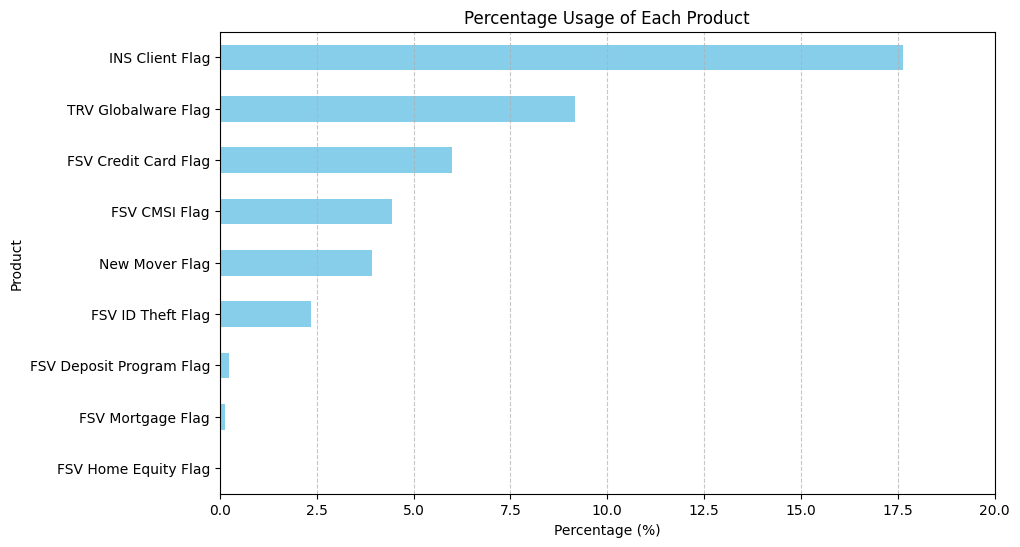

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `member_data` is already loaded and `product_flags` is defined

# List of product flag columns
product_flags = [
    'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
    'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
    'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag'
]

# Calculate the percentage usage for each product
total_count = len(member_data)
percent_usage = {}

for flag in product_flags:
    if member_data[flag].dtype != 'int64' and member_data[flag].dtype != 'float64':
        print(f"Converting {flag} to binary format...")
        member_data[flag] = member_data[flag].apply(lambda x: 1 if x == 'Y' else 0)

    count_ones = member_data[flag].sum()  # Sum counts the number of 1s
    percent_usage[flag] = (count_ones / total_count) * 100

# Convert to DataFrame for easier plotting
usage_df = pd.DataFrame.from_dict(percent_usage, orient='index', columns=['Percentage'])

# Sort the DataFrame by percentage for better visualization
usage_df.sort_values(by='Percentage', inplace=True)

# Plot the percentage usage as a horizontal bar chart
plt.figure(figsize=(10, 6))
usage_df['Percentage'].plot(kind='barh', color='skyblue')
plt.title('Percentage Usage of Each Product')
plt.xlabel('Percentage (%)')
plt.ylabel('Product')
plt.xlim(0, 20)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Checkpoint 2: Divide your data into training and validation sets
# Split the data into training and validation sets
train_data, valid_data = train_test_split(household_data, test_size=0.2, random_state=42)
print(f"Training Data Shape: {train_data.shape}")
print(f"Validation Data Shape: {valid_data.shape}")

# Check available columns in train and validation data
print("Columns in training data:", list(train_data.columns))
print("Columns in validation data:", list(valid_data.columns))

# Identify the missing columns for the feature list
required_features = ['Products Purchased', 'Member Tenure Years', 'Number of Members in Household',
                     'Membership Level', 'Total Roadside Service Cost', 'ERS Member Cost Year 1',
                     'ERS Member Cost Year 2', 'ERS Member Cost Year 3', 'Use of Roadside Service',
                     'Frequency of Roadside Service']

missing_features = [feature for feature in required_features if feature not in train_data.columns]
print(f"Missing features in training data: {missing_features}")

# Adjust the features list based on available columns
features = [feature for feature in required_features if feature in train_data.columns]
print(f"Using features for model training: {features}")

Training Data Shape: (4192, 20)
Validation Data Shape: (1049, 20)
Columns in training data: ['Household Key', 'Products Purchased', 'Member Tenure Years', 'Number of Members in Household', 'Membership Level', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3', 'Use of Roadside Service', 'Frequency of Roadside Service', 'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag', 'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag', 'Total Roadside Service Cost']
Columns in validation data: ['Household Key', 'Products Purchased', 'Member Tenure Years', 'Number of Members in Household', 'Membership Level', 'ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3', 'Use of Roadside Service', 'Frequency of Roadside Service', 'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag', 'INS Clie

Training models for FSV CMSI Flag...
Decision Tree Accuracy for FSV CMSI Flag: 0.87
Bagging Classifier Accuracy for FSV CMSI Flag: 0.91
Training models for FSV Credit Card Flag...
Decision Tree Accuracy for FSV Credit Card Flag: 0.83
Bagging Classifier Accuracy for FSV Credit Card Flag: 0.87
Training models for FSV Deposit Program Flag...
Decision Tree Accuracy for FSV Deposit Program Flag: 0.99
Bagging Classifier Accuracy for FSV Deposit Program Flag: 0.99
Training models for FSV Home Equity Flag...
Decision Tree Accuracy for FSV Home Equity Flag: 1.00
Bagging Classifier Accuracy for FSV Home Equity Flag: 1.00
Training models for FSV ID Theft Flag...
Decision Tree Accuracy for FSV ID Theft Flag: 0.92
Bagging Classifier Accuracy for FSV ID Theft Flag: 0.95
Training models for FSV Mortgage Flag...
Decision Tree Accuracy for FSV Mortgage Flag: 0.99
Bagging Classifier Accuracy for FSV Mortgage Flag: 1.00
Training models for INS Client Flag...
Decision Tree Accuracy for INS Client Flag: 0.

<Figure size 1200x600 with 0 Axes>

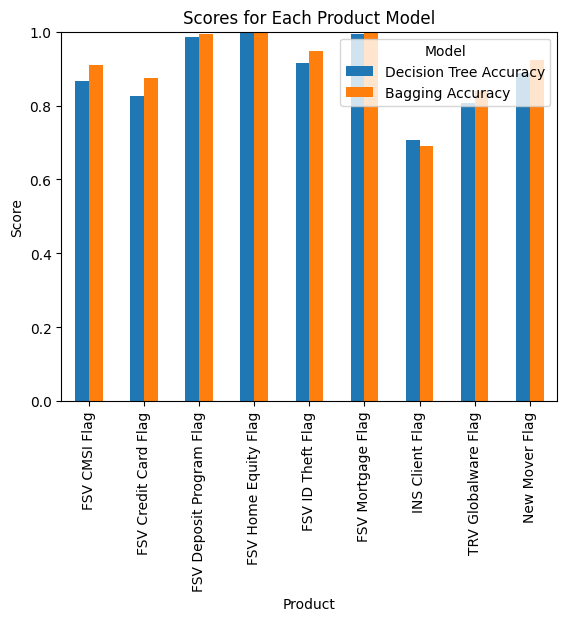

In [ ]:
# Adjusted train_classification_models function
def train_classification_models(X_train, X_valid, product_columns):
    """
    Train and evaluate classification models.
    """
    # Initialize all possible keys for scores
    product_scores = {
        'Product': [],
        'Decision Tree AUC': [],
        'Bagging AUC': [],
        'Decision Tree Accuracy': [],
        'Bagging Accuracy': []
    }

    # Loop through each product for individual modeling
    for product in product_columns:
        print(f"Training models for {product}...")

        # Prepare data for product
        y_train_prod = train_data[product]
        y_valid_prod = valid_data[product]

        # Initialize models with default parameters
        decision_tree = DecisionTreeClassifier(random_state=42)
        bagging_cls = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)

        # Check if the target variable is binary or multi-class
        if y_train_prod.nunique() == 2:
            # Binary Classification
            decision_tree.fit(X_train, y_train_prod)
            y_pred_tree = decision_tree.predict_proba(X_valid)[:, 1]
            tree_score = roc_auc_score(y_valid_prod, y_pred_tree)

            bagging_cls.fit(X_train, y_train_prod)
            y_pred_bagging = bagging_cls.predict_proba(X_valid)[:, 1]
            bagging_score = roc_auc_score(y_valid_prod, y_pred_bagging)

            metric_name = 'AUC'
        else:
            # Multi-Class Classification or Regression
            decision_tree.fit(X_train, y_train_prod)
            y_pred_tree = decision_tree.predict(X_valid)
            tree_score = accuracy_score(y_valid_prod, y_pred_tree)

            bagging_cls.fit(X_train, y_train_prod)
            y_pred_bagging = bagging_cls.predict(X_valid)
            bagging_score = accuracy_score(y_valid_prod, y_pred_bagging)

            metric_name = 'Accuracy'

        print(f"Decision Tree {metric_name} for {product}: {tree_score:.2f}")
        print(f"Bagging Classifier {metric_name} for {product}: {bagging_score:.2f}")

        # Store results in the correct key
        product_scores['Product'].append(product)

        if metric_name == 'AUC':
            product_scores['Decision Tree AUC'].append(tree_score)
            product_scores['Bagging AUC'].append(bagging_score)
            product_scores['Decision Tree Accuracy'].append(None)  # Placeholder for consistency
            product_scores['Bagging Accuracy'].append(None)  # Placeholder for consistency
        else:
            product_scores['Decision Tree Accuracy'].append(tree_score)
            product_scores['Bagging Accuracy'].append(bagging_score)
            product_scores['Decision Tree AUC'].append(None)  # Placeholder for consistency
            product_scores['Bagging AUC'].append(None)  # Placeholder for consistency)

    return product_scores

# Prepare data for classification
X_train_cls = train_data[features]
X_valid_cls = valid_data[features]

# Train and evaluate models for each product
product_scores = train_classification_models(X_train_cls, X_valid_cls, product_flags)

# Convert results to DataFrame for visualization
scores_df = pd.DataFrame(product_scores)

# Checkpoint 3: Visualize the Scores for each product
plt.figure(figsize=(12, 6))
scores_df.set_index('Product').plot(kind='bar', stacked=False)
plt.title('Scores for Each Product Model')
plt.ylabel('Score')
plt.xlabel('Product')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()


Decision Tree Regressor RMSE: 25.82
Bagging Regressor RMSE: 11.16
Cross-Validation RMSE Scores for Regression Model: [181.10770796  13.28273469  51.07345511  43.1128243   94.51969062]
Mean CV RMSE Score: 76.62


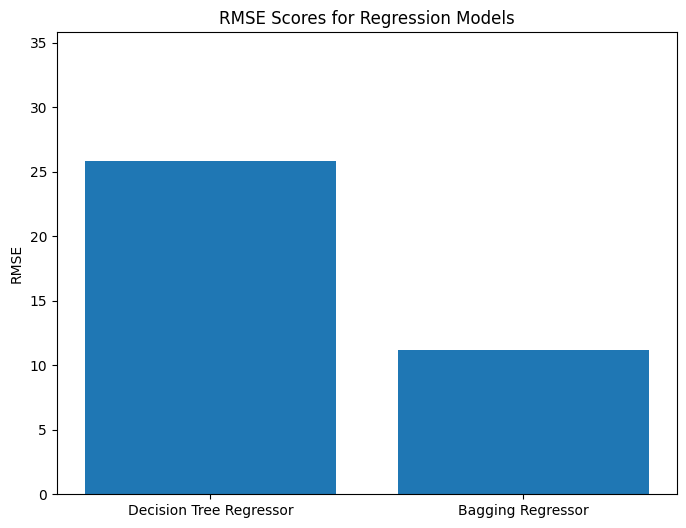

In [ ]:
# Updated train_regression_models function
def train_regression_models(X_train, X_valid):
    """
    Train and evaluate regression models.
    """
    # Initialize models with default parameters
    decision_tree_reg = DecisionTreeRegressor(random_state=42)
    bagging_reg = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)

    # Train Decision Tree Regressor
    decision_tree_reg.fit(X_train, train_data['Total Roadside Service Cost'])
    y_pred_tree = decision_tree_reg.predict(X_valid)
    tree_rmse = mean_squared_error(valid_data['Total Roadside Service Cost'], y_pred_tree, squared=False)

    # Train Bagging Regressor
    bagging_reg.fit(X_train, train_data['Total Roadside Service Cost'])
    y_pred_bagging = bagging_reg.predict(X_valid)
    bagging_rmse = mean_squared_error(valid_data['Total Roadside Service Cost'], y_pred_bagging, squared=False)

    print(f"Decision Tree Regressor RMSE: {tree_rmse:.2f}")
    print(f"Bagging Regressor RMSE: {bagging_rmse:.2f}")

    # Cross-validation scores for Decision Tree Regressor
    cv_scores = cross_val_score(decision_tree_reg, X_train, train_data['Total Roadside Service Cost'], cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-Validation RMSE Scores for Regression Model: {np.sqrt(-cv_scores)}")
    print(f"Mean CV RMSE Score: {np.sqrt(-cv_scores).mean():.2f}")

    return tree_rmse, bagging_rmse

# Train and evaluate regression models
tree_rmse, bagging_rmse = train_regression_models(X_train_cls, X_valid_cls)

# Checkpoint 4: Visualize the regression model results
plt.figure(figsize=(8, 6))
plt.bar(['Decision Tree Regressor', 'Bagging Regressor'], [tree_rmse, bagging_rmse])
plt.title('RMSE Scores for Regression Models')
plt.ylabel('RMSE')
plt.ylim(0, max(tree_rmse, bagging_rmse) + 10)
plt.show()


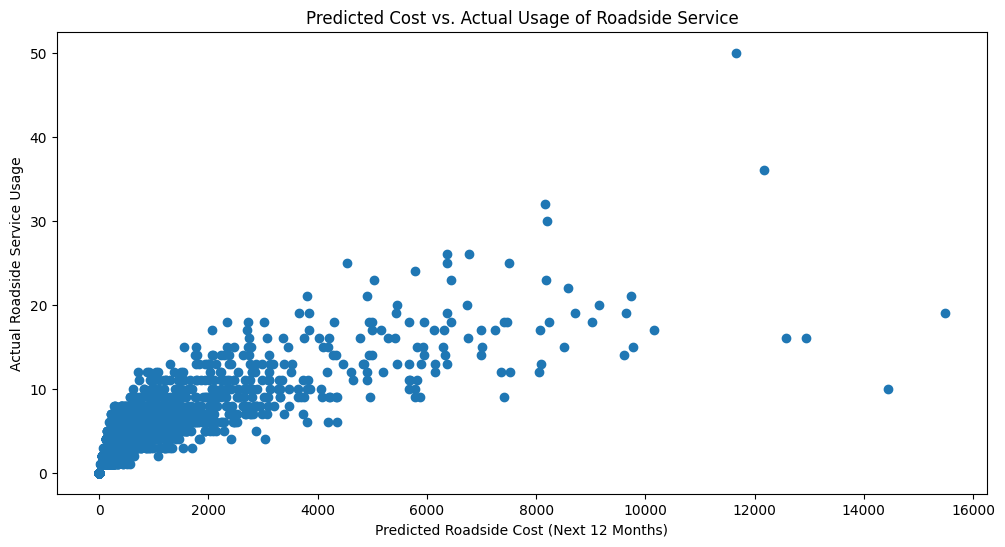

In [ ]:
# Checkpoint 5: Score all members and calculate probabilities and predictions

# Combine training and validation sets for scoring
all_data = pd.concat([train_data, valid_data])

# Initialize models for scoring
bagging_cls = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)

# Score members for the likelihood of purchasing each product
for product in product_flags:
    X = all_data[features]
    X.fillna(X.median(), inplace=True)

    y = all_data[product].fillna(0)  # Assume missing product purchase means not purchased (0)

    # Train Bagging Classifier on all data
    bagging_cls.fit(X, y)

    # Score all members
    all_data[f'{product}_Probability'] = bagging_cls.predict_proba(X)[:, 1]

# Score for roadside usage and cost
X = all_data[features]
X.fillna(X.median(), inplace=True)
y = all_data['Total Roadside Service Cost'].fillna(all_data['Total Roadside Service Cost'].median())

# Initialize Bagging Regressor
bagging_reg = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=42)

# Train Bagging Regressor on all data
bagging_reg.fit(X, y)

# Score all members
all_data['Roadside_Cost_Prediction'] = bagging_reg.predict(X)

# Checkpoint 5: Visualize scoring results
plt.figure(figsize=(12, 6))
plt.scatter(all_data['Roadside_Cost_Prediction'], all_data['Use of Roadside Service'])
plt.title('Predicted Cost vs. Actual Usage of Roadside Service')
plt.xlabel('Predicted Roadside Cost (Next 12 Months)')
plt.ylabel('Actual Roadside Service Usage')
plt.show()


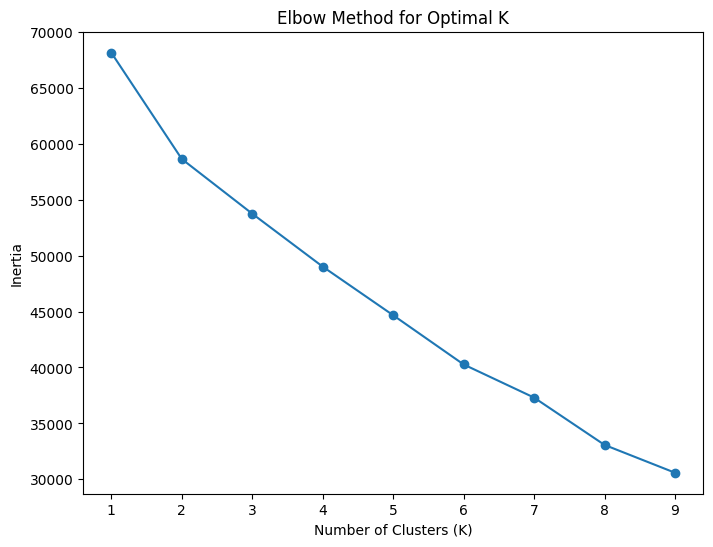

In [ ]:
# Checkpoint 6: Clustering/Segmentation of Members (Using Elbow Method for K)
# Normalize features before clustering
scaler = StandardScaler()
clustering_features = ['Member Tenure Years', 'Number of Members in Household', 'Products Purchased',
                       'Membership Level'] + [f'{product}_Probability' for product in product_flags] + ['Roadside_Cost_Prediction']
all_data[clustering_features] = scaler.fit_transform(all_data[clustering_features])

# Elbow method for determining the optimal number of clusters
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(all_data[clustering_features])
    inertia.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

# Using optimal K for clustering (let's assume 5 for this example)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
all_data['Cluster'] = kmeans.fit_predict(all_data[clustering_features])


In [ ]:
# Ensure required columns exist before aggregation
required_columns = ['Frequency of Roadside Service', 'Membership Level', 'Number of Members in Household', 'Use of Roadside Service']

# Check for missing columns and create if necessary
for col in required_columns:
    if col not in member_data.columns:
        print(f"Creating missing column: {col}")
        if col == 'Frequency of Roadside Service':
            member_data[col] = member_data[['ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3']].gt(0).sum(axis=1)
        elif col == 'Membership Level':
            # Assuming this is derived from 'Plus Indicator Description'
            member_data['Membership Level'] = member_data['Plus Indicator Description'].map(membership_mapping)
        elif col == 'Number of Members in Household':
            member_data['Number of Members in Household'] = 1  # Assuming at least 1 if no info is available
        elif col == 'Use of Roadside Service':
            member_data['Use of Roadside Service'] = np.where(
                (member_data['ERS Member Cost Year 1'] > 0) |
                (member_data['ERS Member Cost Year 2'] > 0) |
                (member_data['ERS Member Cost Year 3'] > 0), 1, 0
            )

# Convert product flags to binary if necessary
product_flags = ['FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
                 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
                 'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag']

# Ensure all product flag columns are numeric
for flag in product_flags:
    if member_data[flag].dtype != 'int64':
        member_data[flag] = member_data[flag].apply(lambda x: 1 if x == 'Y' else 0)

# Proceed with household-level aggregation
household_data = member_data.groupby('Household Key').agg({
    'Products Purchased': 'sum',
    'Member Tenure Years': 'max',
    'Number of Members in Household': 'max',
    'Membership Level': 'first',
    'ERS Member Cost Year 1': 'sum',
    'ERS Member Cost Year 2': 'sum',
    'ERS Member Cost Year 3': 'sum',
    'Use of Roadside Service': 'sum',
    'Frequency of Roadside Service': 'sum',
    **{flag: 'sum' for flag in product_flags}
}).reset_index()

# Display the aggregated household data to verify
print("Aggregated Household Data with Correct 'Products Purchased':")
print(household_data.head())


Creating missing column: Frequency of Roadside Service
Creating missing column: Membership Level
Creating missing column: Number of Members in Household
Creating missing column: Use of Roadside Service
Aggregated Household Data with Correct 'Products Purchased':
   Household Key  Products Purchased  Member Tenure Years  \
0          875.0               162.0                 64.0   
1          969.0                54.0                 54.0   
2         3338.0                27.0                 67.0   
3         8718.0                18.0                 13.0   
4        11524.0                63.0                 44.0   

   Number of Members in Household  Membership Level  ERS Member Cost Year 1  \
0                               1               1.0                  647.35   
1                               1               2.0                    0.00   
2                               1               1.0                    0.00   
3                               1               1.0   

In [ ]:


# Recalculate total roadside service cost
household_data['Total Roadside Service Cost'] = household_data[
    ['ERS Member Cost Year 1', 'ERS Member Cost Year 2', 'ERS Member Cost Year 3']
].sum(axis=1)

# Display to check values after aggregation
print("Aggregated Household Data Sample:")
print(household_data.head())

# Proceed with clustering and further analysis as needed
# (Code for clustering and visualization remains the same)


Aggregated Household Data Sample:
   Household Key  Products Purchased  Member Tenure Years  \
0          875.0               162.0                 64.0   
1          969.0                54.0                 54.0   
2         3338.0                27.0                 67.0   
3         8718.0                18.0                 13.0   
4        11524.0                63.0                 44.0   

   Number of Members in Household  Membership Level  ERS Member Cost Year 1  \
0                               1               1.0                  647.35   
1                               1               2.0                    0.00   
2                               1               1.0                    0.00   
3                               1               1.0                    0.00   
4                               1               1.0                  117.70   

   ERS Member Cost Year 2  ERS Member Cost Year 3  Use of Roadside Service  \
0                  353.10                 1245

In [ ]:
# Recommendations based on clustering
print("Recommendations:")
print("1. Focus marketing efforts on clusters with higher probabilities of purchasing new products.")
print("2. Develop targeted roadside assistance plans for clusters with high predicted roadside usage costs.")
print("3. Create loyalty programs for clusters with long-tenure members to retain them and encourage product upgrades.")


Recommendations:
1. Focus marketing efforts on clusters with higher probabilities of purchasing new products.
2. Develop targeted roadside assistance plans for clusters with high predicted roadside usage costs.
3. Create loyalty programs for clusters with long-tenure members to retain them and encourage product upgrades.


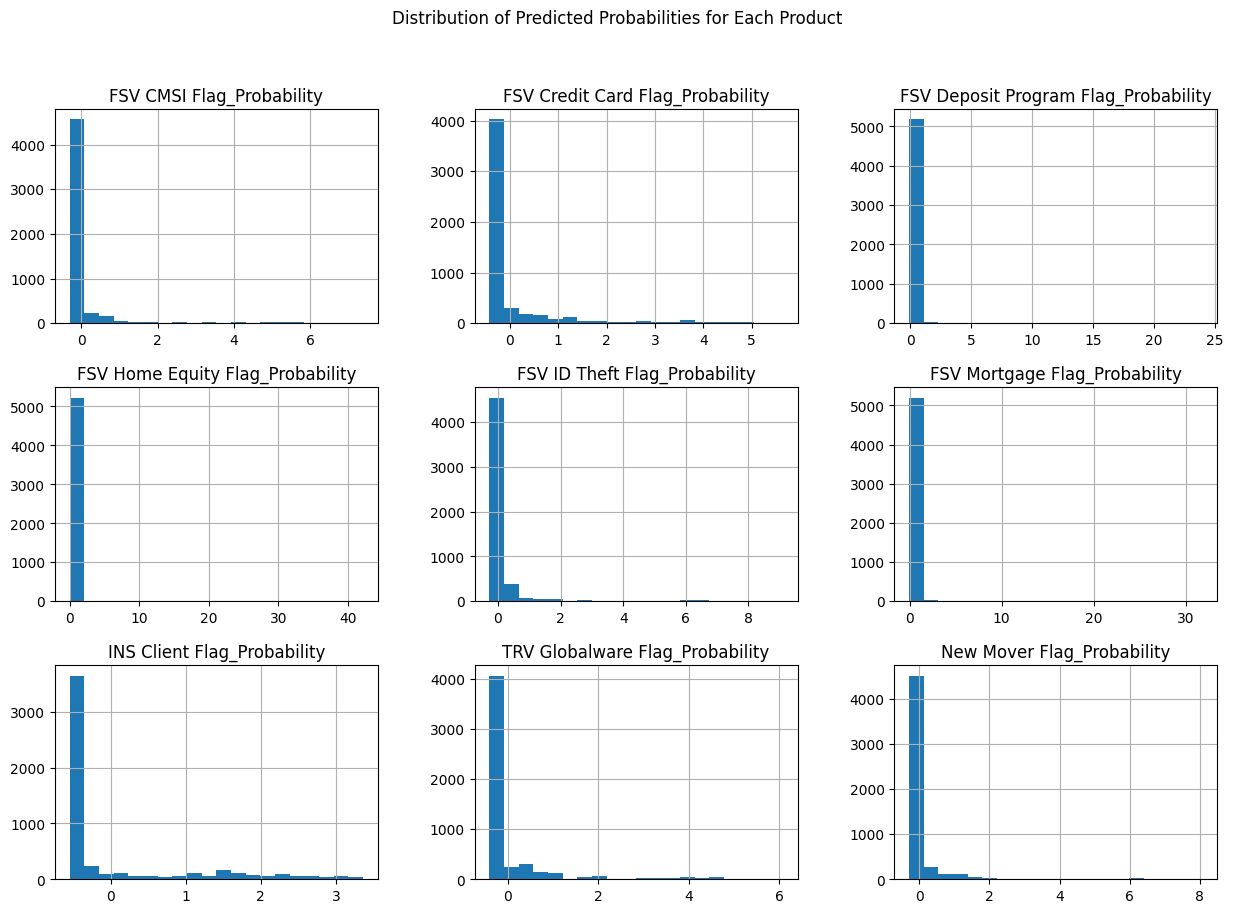

In [ ]:
all_data[[f'{product}_Probability' for product in product_flags]].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribution of Predicted Probabilities for Each Product')
plt.show()

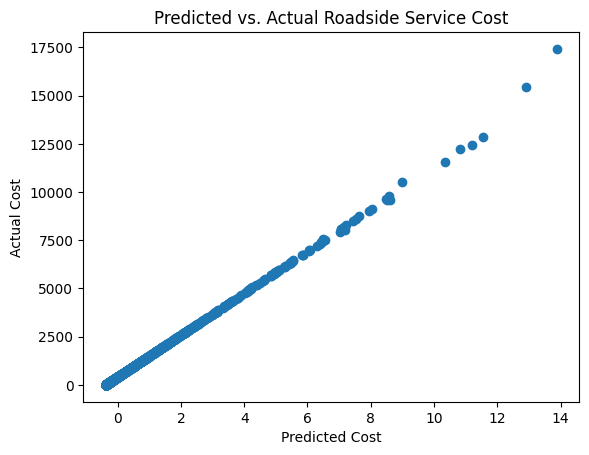

In [ ]:
plt.scatter(all_data['Roadside_Cost_Prediction'], all_data['Total Roadside Service Cost'])
plt.title('Predicted vs. Actual Roadside Service Cost')
plt.xlabel('Predicted Cost')
plt.ylabel('Actual Cost')
plt.show()


<Figure size 1200x800 with 0 Axes>

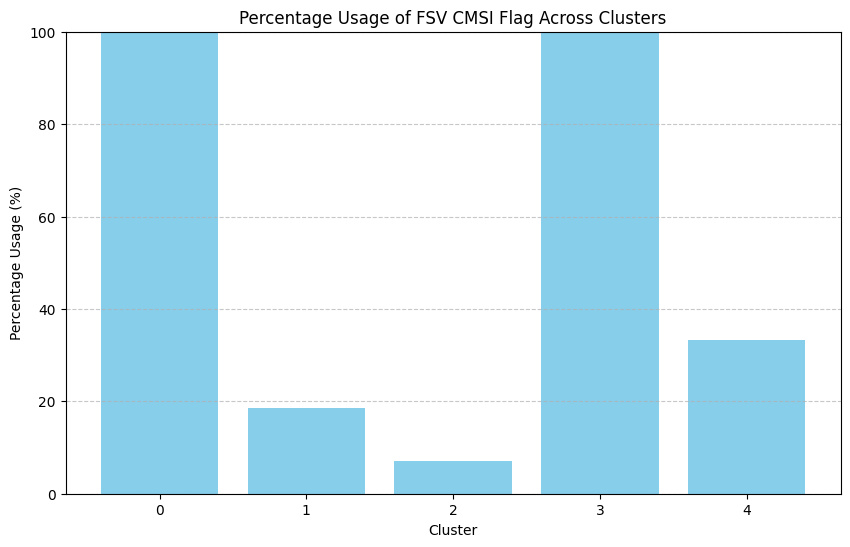

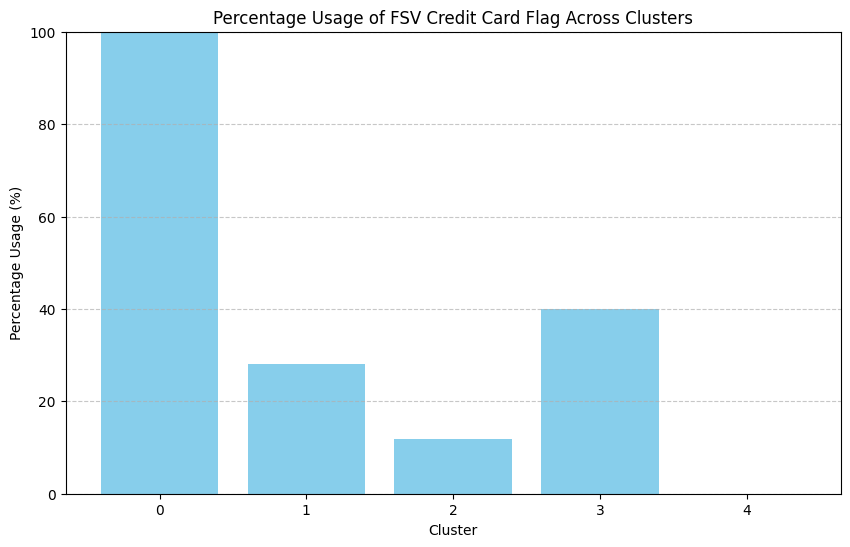

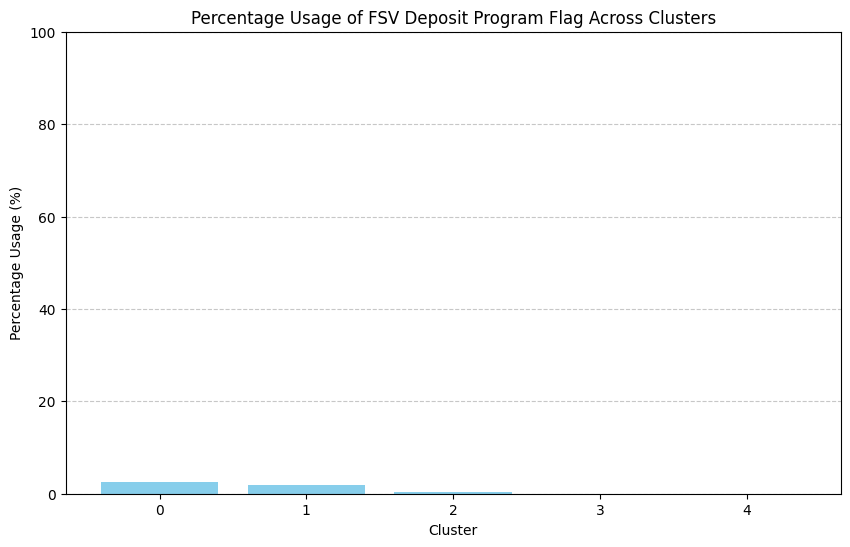

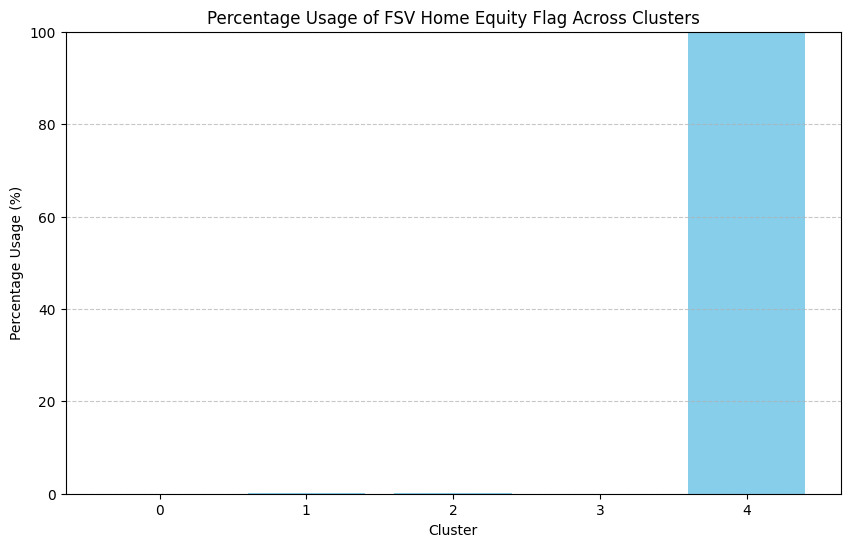

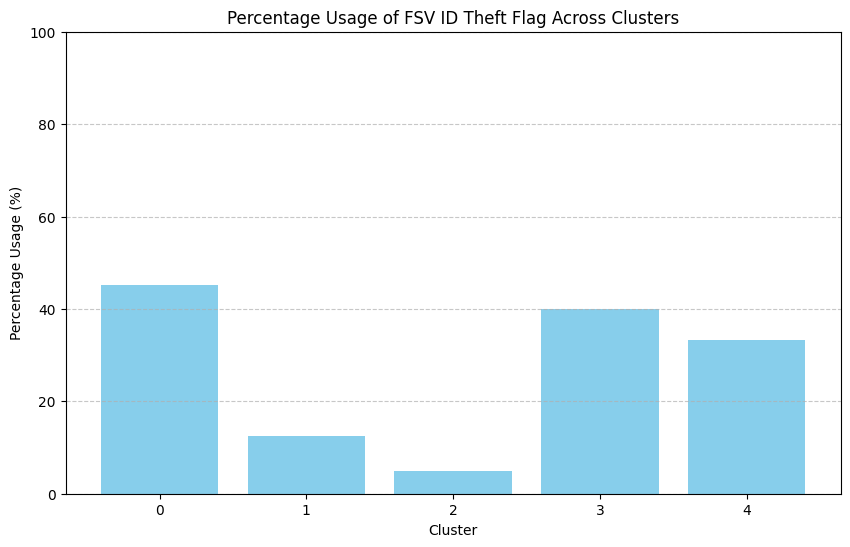

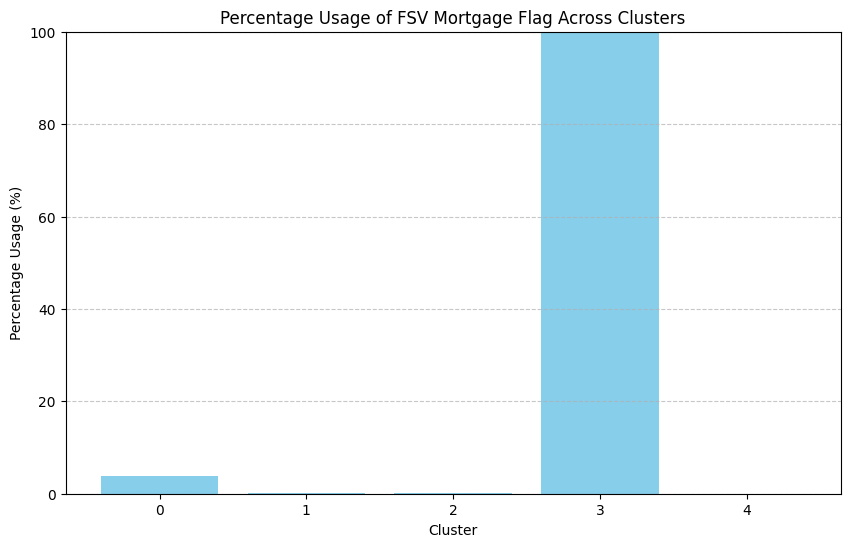

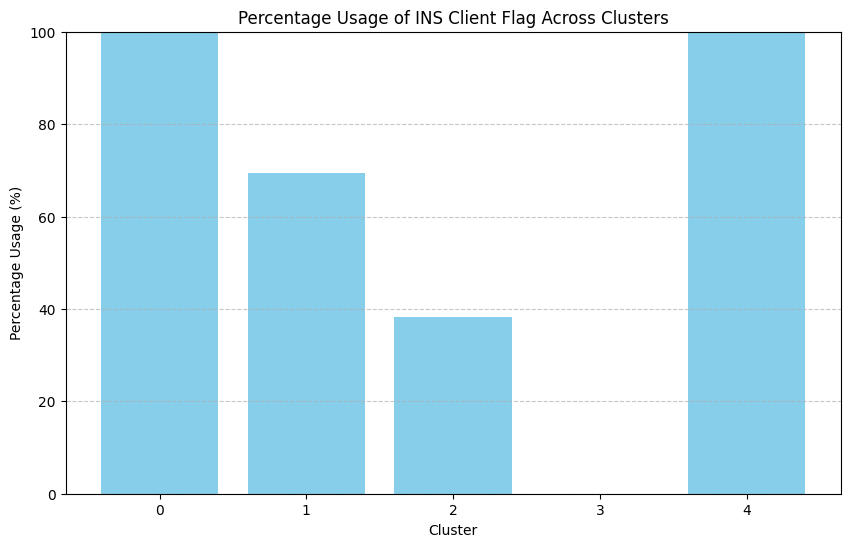

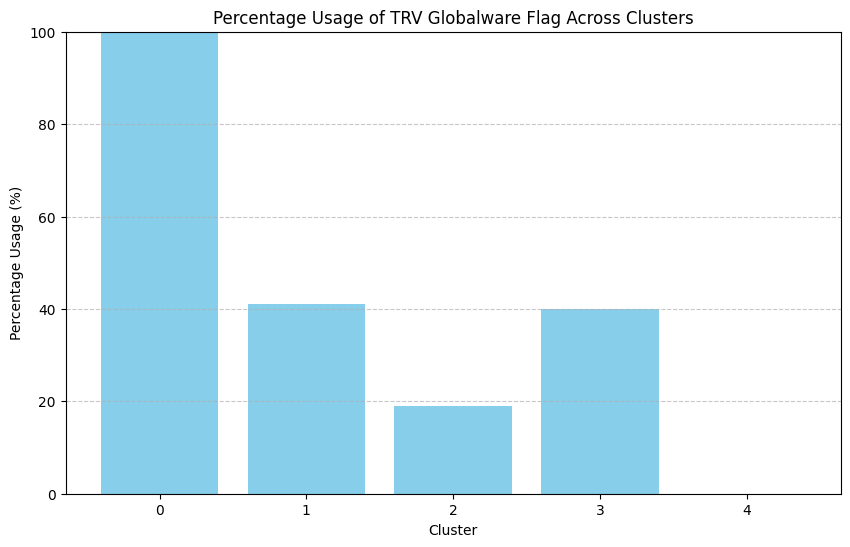

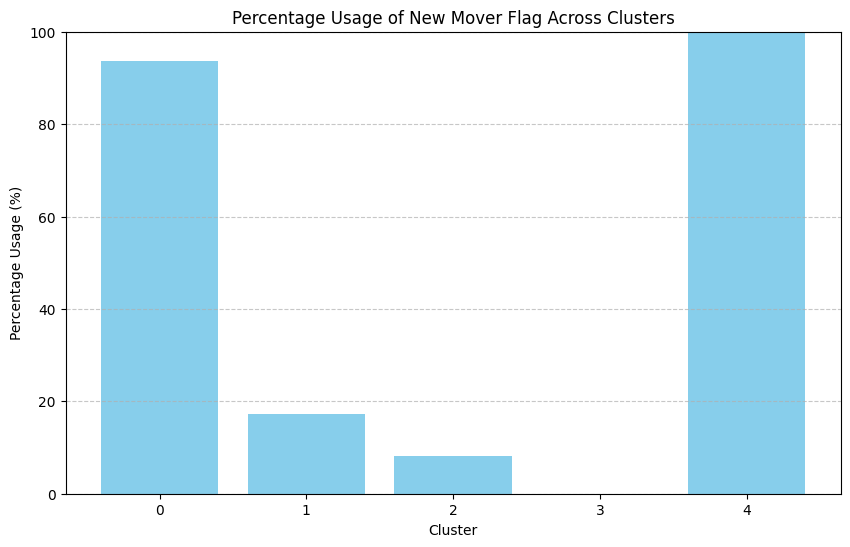

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `all_data` is your DataFrame with cluster labels and product flags

# List of product flag columns
product_flags = [
    'FSV CMSI Flag', 'FSV Credit Card Flag', 'FSV Deposit Program Flag',
    'FSV Home Equity Flag', 'FSV ID Theft Flag', 'FSV Mortgage Flag',
    'INS Client Flag', 'TRV Globalware Flag', 'New Mover Flag'
]

# Check if 'Cluster' column is in the dataframe
if 'Cluster' not in all_data.columns:
    print("Error: 'Cluster' column is missing. Ensure clustering is performed before this step.")
else:
    # Calculate the percentage usage for each product by cluster
    cluster_usage = all_data.groupby('Cluster')[product_flags].mean() * 100

    # Plot the percentage usage for each product by cluster
    plt.figure(figsize=(12, 8))

    for flag in product_flags:
        plt.figure(figsize=(10, 6))
        plt.bar(cluster_usage.index, cluster_usage[flag], color='skyblue')
        plt.title(f'Percentage Usage of {flag} Across Clusters')
        plt.xlabel('Cluster')
        plt.ylabel('Percentage Usage (%)')
        plt.ylim(0, 100)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


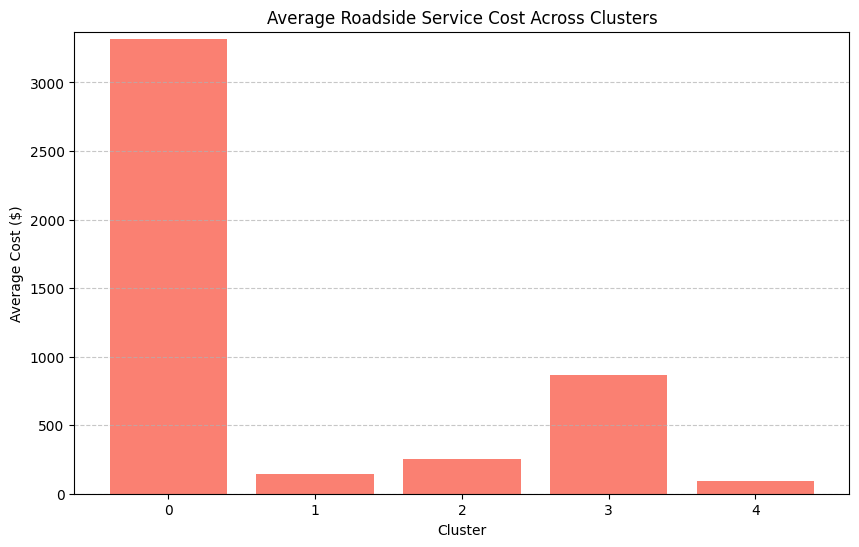

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `all_data` is your DataFrame with cluster labels and 'Total Roadside Service Cost' column

# Check if 'Cluster' and 'Total Roadside Service Cost' columns are in the dataframe
if 'Cluster' not in all_data.columns or 'Total Roadside Service Cost' not in all_data.columns:
    print("Error: Required columns are missing. Ensure clustering is performed and cost data is available.")
else:
    # Calculate the average cost of roadside service usage by cluster
    cluster_cost = all_data.groupby('Cluster')['Total Roadside Service Cost'].mean()

    # Plot the average cost for each cluster
    plt.figure(figsize=(10, 6))
    plt.bar(cluster_cost.index, cluster_cost, color='salmon')
    plt.title('Average Roadside Service Cost Across Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Average Cost ($)')
    plt.ylim(0, cluster_cost.max() + 50)  # Add some padding to the y-axis
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
import pandas as pd

# Set a threshold to identify target households
threshold = 0.8  # Adjust this based on your analysis needs

# Initialize a list to store the results
results = []

# Iterate over each product flag to calculate the desired metrics
for product in product_flags:
    # Ensure probabilities are within the correct range
    all_data[f'{product}_Probability'] = all_data[f'{product}_Probability'].clip(0, 1)

    # Filter target and non-target households based on threshold
    target_households = all_data[all_data[f'{product}_Probability'] > threshold]
    non_target_households = all_data[all_data[f'{product}_Probability'] <= threshold]

    # Calculate the number of targeted households
    targeted_household_size = target_households.shape[0]

    # Calculate average probability of purchase for target and non-target households
    avg_prob_purchase_target = target_households[f'{product}_Probability'].mean() if not target_households.empty else 0
    avg_prob_purchase_non_target = non_target_households[f'{product}_Probability'].mean() if not non_target_households.empty else 0

    # Store the results
    results.append({
        'Product Targeted': product,
        'Targeted Household Size*': targeted_household_size,
        'Avg Prob. of Purchase (Target HHs)': avg_prob_purchase_target,
        'Avg Prob. of Purchase (Non Target HHs)': avg_prob_purchase_non_target
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Display the resulting table
print("Product Targeted Table:")
print(results_df)


Product Targeted Table:
           Product Targeted  Targeted Household Size*  \
0             FSV CMSI Flag                       322   
1      FSV Credit Card Flag                       592   
2  FSV Deposit Program Flag                        72   
3      FSV Home Equity Flag                        25   
4         FSV ID Theft Flag                       276   
5         FSV Mortgage Flag                        42   
6           INS Client Flag                      1000   
7       TRV Globalware Flag                       496   
8            New Mover Flag                       370   

   Avg Prob. of Purchase (Target HHs)  Avg Prob. of Purchase (Non Target HHs)  
0                            0.986428                                0.030158  
1                            0.983305                                0.039005  
2                            0.990517                                0.013831  
3                            1.000000                                0.000000  
4    